In [88]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import librosa
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from skimage.transform import resize

device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [89]:
data_df=pd.read_csv("C:/Users/nihal/Downloads/archive (2)/files_paths.csv")
print(data_df['Class'].unique())
print()
print(len(data_df['Class'].unique())) 
data_df.head()

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']

12


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [90]:
data_df["FilePath"]='C:/Users/nihal/Downloads/archive (2)/Dataset'+data_df["FilePath"].str[1:]
data_df.head()

,FilePath,Class
0,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
1,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
2,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
3,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
4,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan


In [91]:
data_df["FilePath"].iloc[2]

'C:/Users/nihal/Downloads/archive (2)/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

In [ ]:
counts = data_df['Class'].value_counts()
perc   = data_df['Class'].value_counts(normalize=True) * 100

print("Data shape:", data_df.shape)
print("\nSamples per class (count):\n", counts)
print("\nSamples per class (%):\n", perc.round(2))

# quick check for issues
print("\nNulls per column:\n", data_df.isnull().sum())
print("Duplicate rows:", data_df.duplicated().sum())


Data shape: (6687, 2)

Samples per class (count):
 Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64

Samples per class (%):
 Class
Saud_Alshuraim          10.41
Saad_Alghamdi           10.29
AbdulRahman_Alsudais     9.69
Yasser_Aldossary         8.61
Ali_Alhothaify           8.61
Bander_Balilah           8.61
Maher_Almuaiqly          8.61
Abdullah_Albuaijan       7.54
Mohammed_Ayoub           7.18
Nasser_Alqutami          6.82
AbdulBari_Althubaity     6.82
Mohammed_Aluhaidan       6.80
Name: proportion, dtype: float64

Nulls per column:
 FilePath    0
Class       0
dtype: int64
Duplicate rows: 0


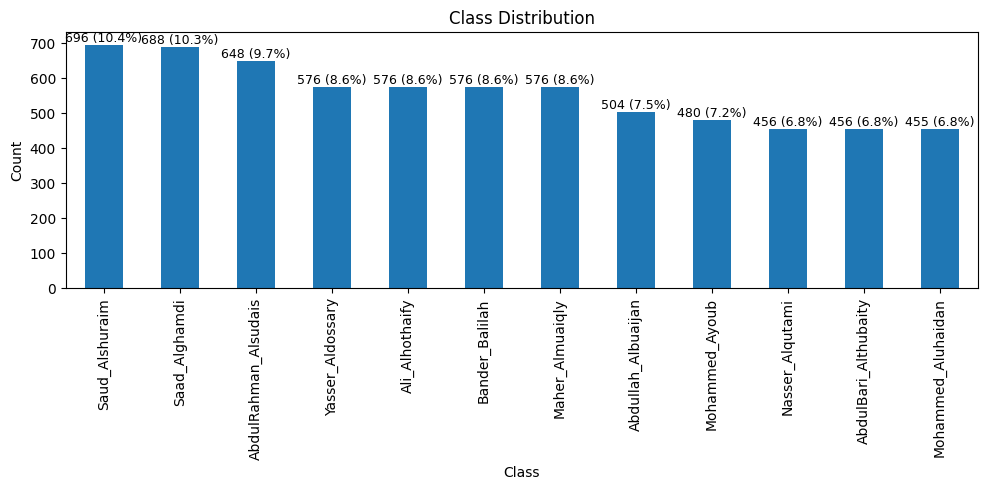

In [ ]:
counts = data_df['Class'].value_counts().sort_values(ascending=False)
perc   = (counts / counts.sum() * 100).round(1)

plt.figure(figsize=(10,5))
ax = counts.plot(kind='bar')
ax.set_title("Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
# add percent labels on top of bars
for p, pct in zip(ax.patches, perc):
    ax.annotate(f"{int(p.get_height())} ({pct}%)",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Keep original labels
data_df['ClassName'] = data_df['Class']

# Encode
label_encoder = LabelEncoder()
data_df['Class'] = label_encoder.fit_transform(data_df['Class'])

# Save class names for decoding predictions
class_names = label_encoder.classes_.tolist()
print("Classes:", class_names)

# Stratified split (70% train, 15% val, 15% test)
train, temp = train_test_split(
    data_df, test_size=0.3, stratify=data_df['Class'], random_state=7
)
val, test = train_test_split(
    temp, test_size=0.5, stratify=temp['Class'], random_state=7
)

print("Train shape:", train.shape)
print("Val shape:", val.shape)
print("Test shape:", test.shape)

Classes: ['AbdulBari_Althubaity', 'AbdulRahman_Alsudais', 'Abdullah_Albuaijan', 'Ali_Alhothaify', 'Bander_Balilah', 'Maher_Almuaiqly', 'Mohammed_Aluhaidan', 'Mohammed_Ayoub', 'Nasser_Alqutami', 'Saad_Alghamdi', 'Saud_Alshuraim', 'Yasser_Aldossary']
Train shape: (4680, 3)
Val shape: (1003, 3)
Test shape: (1004, 3)


In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe, sr=22050, duration=5, img_height=128, img_width=256):
        self.dataframe = dataframe.reset_index(drop=True)
        self.labels = dataframe["Class"].tolist()
        self.sr = sr
        self.duration = duration
        self.img_height = img_height
        self.img_width = img_width

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe['FilePath'].iloc[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Compute spectrogram on-the-fly
        spec = self.get_spectrogram(file_path)

        # Add channel dimension [1, H, W]
        spec_tensor = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)

        return spec_tensor, label

    def get_spectrogram(self, file_path):
        signal, sr = librosa.load(file_path, sr=self.sr, duration=self.duration)
        spec = librosa.feature.melspectrogram(
            y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=self.img_height
        )
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # Pad or crop to fixed width instead of resize
        expected_width = (self.duration * self.sr) // 512 + 1
        if spec_db.shape[1] < expected_width:
            pad_width = expected_width - spec_db.shape[1]
            spec_db = np.pad(spec_db, ((0, 0), (0, pad_width)), mode="constant")
        else:
            spec_db = spec_db[:, :expected_width]
        
        spec_db = (spec_db - spec_db.mean()) / (spec_db.std() + 1e-6)

        return spec_db


In [96]:
train_dataset=CustomAudioDataset(dataframe=train)  
val_dataset=CustomAudioDataset(dataframe=val)
test_dataset=CustomAudioDataset(dataframe=test)

In [97]:
lr=0.001
Batch_size=32
EPOCHS=25

In [98]:
train_loader=DataLoader(dataset=train_dataset,batch_size=Batch_size,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=Batch_size,shuffle=False)
test_loader=DataLoader(dataset=test_dataset,batch_size=Batch_size,shuffle=False)

In [99]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        # 🔑 dynamically calculate flatten size using a dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)   # match dataset sample shape
            out = self.pool(self.relu(self.conv1(dummy)))
            out = self.pool(self.relu(self.conv2(out)))
            out = self.pool(self.relu(self.conv3(out)))
            n_features = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(n_features, 512)
        self.fc2 = nn.Linear(512, 128)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.output(x)

In [100]:
# get input shape dynamically from dataset
sample, _ = train_dataset[0]
input_shape = tuple(sample.shape)  # (1, H, W)

num_classes = len(label_encoder.classes_)
model = AudioClassifier(num_classes=num_classes, input_shape=input_shape).to(device)
print(model)

AudioClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=27648, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=12, bias=True)
)


In [102]:
from torchsummary import summary
sample, _ = train_dataset[0]
print("Sample shape from dataset:", sample.shape)

summary(model, input_size=sample.shape)

Sample shape from dataset: torch.Size([1, 128, 216])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 216]             160
              ReLU-2         [-1, 16, 128, 216]               0
         MaxPool2d-3          [-1, 16, 64, 108]               0
            Conv2d-4          [-1, 32, 64, 108]           4,640
              ReLU-5          [-1, 32, 64, 108]               0
         MaxPool2d-6           [-1, 32, 32, 54]               0
            Conv2d-7           [-1, 64, 32, 54]          18,496
              ReLU-8           [-1, 64, 32, 54]               0
         MaxPool2d-9           [-1, 64, 16, 27]               0
          Flatten-10                [-1, 27648]               0
           Linear-11                  [-1, 512]      14,156,288
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]   

In [103]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion=nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [104]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    total_loss_train, total_acc_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (torch.argmax(outputs, dim=1) == labels).sum().item()

    avg_train_loss = total_loss_train / len(train_loader)
    avg_train_acc = total_acc_train / len(train_dataset)

    # --- Validation ---
    model.eval()
    total_loss_val, total_acc_val = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            total_loss_val += val_loss.item()
            total_acc_val += (torch.argmax(outputs, dim=1) == labels).sum().item()

    avg_val_loss = total_loss_val / len(val_loader)
    avg_val_acc = total_acc_val / len(val_dataset)

    # --- Scheduler step ---
    scheduler.step(avg_val_loss)

    # --- Logging ---
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(avg_train_acc)
    val_accs.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} "
          f"| Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

print(f"\nTraining complete in {(time.time()-start_time):.2f} seconds")


Epoch 1/25 | Train Loss: 2.0200, Acc: 0.2791 | Val Loss: 0.7812, Acc: 0.7577
Epoch 2/25 | Train Loss: 0.8142, Acc: 0.7297 | Val Loss: 0.2862, Acc: 0.9182
Epoch 3/25 | Train Loss: 0.4435, Acc: 0.8551 | Val Loss: 0.1765, Acc: 0.9462
Epoch 4/25 | Train Loss: 0.3111, Acc: 0.9047 | Val Loss: 0.1351, Acc: 0.9601
Epoch 5/25 | Train Loss: 0.2302, Acc: 0.9288 | Val Loss: 0.1099, Acc: 0.9671
Epoch 6/25 | Train Loss: 0.1785, Acc: 0.9451 | Val Loss: 0.0764, Acc: 0.9791
Epoch 7/25 | Train Loss: 0.1392, Acc: 0.9596 | Val Loss: 0.0494, Acc: 0.9840
Epoch 8/25 | Train Loss: 0.1010, Acc: 0.9699 | Val Loss: 0.0569, Acc: 0.9821
Epoch 9/25 | Train Loss: 0.0868, Acc: 0.9741 | Val Loss: 0.0785, Acc: 0.9771
Epoch 10/25 | Train Loss: 0.1017, Acc: 0.9675 | Val Loss: 0.0605, Acc: 0.9811
Epoch 11/25 | Train Loss: 0.1076, Acc: 0.9701 | Val Loss: 0.0594, Acc: 0.9821
Epoch 12/25 | Train Loss: 0.0612, Acc: 0.9835 | Val Loss: 0.0425, Acc: 0.9870
Epoch 13/25 | Train Loss: 0.0431, Acc: 0.9891 | Val Loss: 0.0371, Acc: 0.

In [105]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    total_acc_test, total_loss_test = 0, 0
    all_preds, all_labels = [], []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_loss_test += loss.item()
        preds = torch.argmax(outputs, dim=1)

        total_acc_test += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_loss_test / len(test_loader)
    avg_test_acc = total_acc_test / len(test_dataset)

print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {avg_test_acc:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Test Loss: 0.0361 | Test Accuracy: 0.9920

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       0.98      1.00      0.99        97
           2       0.96      0.99      0.97        75
           3       1.00      1.00      1.00        87
           4       1.00      0.97      0.98        87
           5       0.99      1.00      0.99        87
           6       0.99      0.97      0.98        68
           7       1.00      0.99      0.99        72
           8       1.00      1.00      1.00        68
           9       1.00      1.00      1.00       103
          10       1.00      1.00      1.00       105
          11       0.99      0.99      0.99        87

    accuracy                           0.99      1004
   macro avg       0.99      0.99      0.99      1004
weighted avg       0.99      0.99      0.99      1004



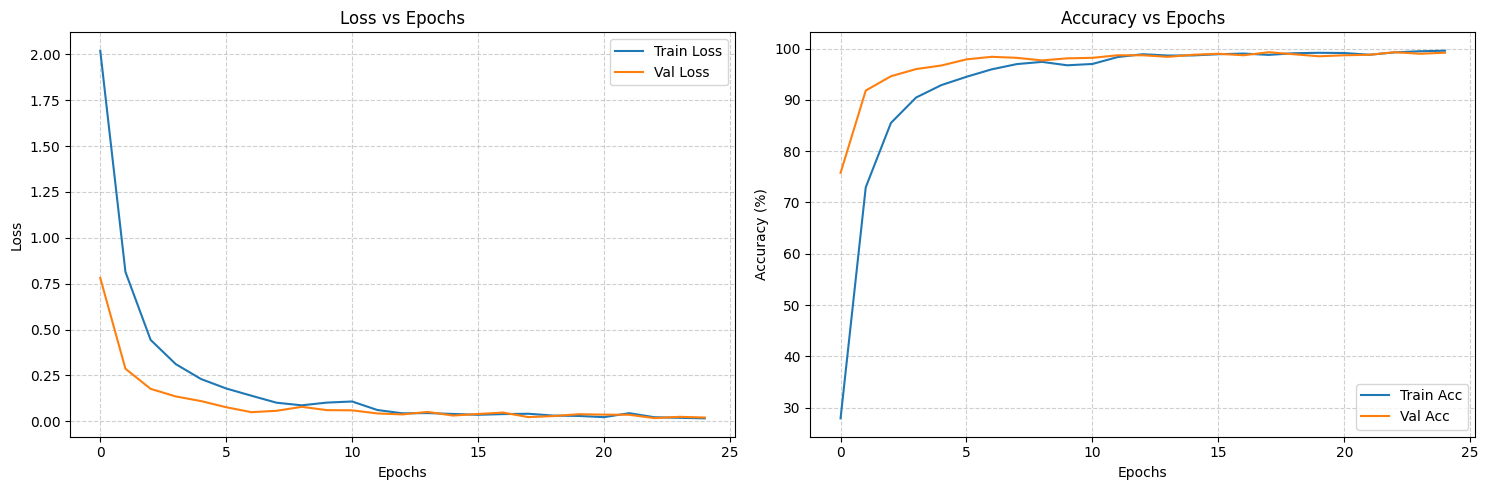

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Loss plot
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_title("Loss vs Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle="--", alpha=0.6)
axs[0].legend()

# Accuracy plot
axs[1].plot([a*100 for a in train_accs], label='Train Acc')
axs[1].plot([a*100 for a in val_accs], label='Val Acc')
axs[1].set_title("Accuracy vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].grid(True, linestyle="--", alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()


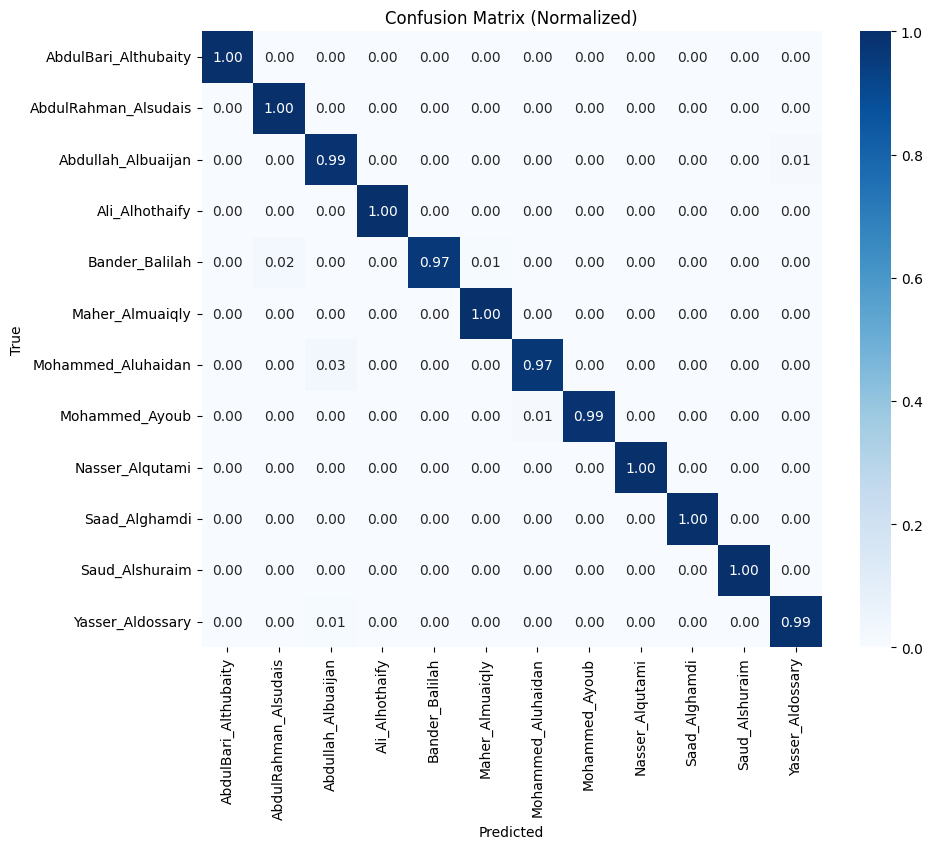

In [108]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize per row

plt.figure(figsize=(10,8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()